In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Naive frequentist approach


### Loading the dataset

In [2]:
malwares = []



lengths=[]
with open('../archive/api/1000_calls.txt') as f :
    for line in f:
        l=line.split(',')
        l=[int(x) for x in l]
        malwares.append(np.array(l))


# we want our words to fill an interval of integers [0... something[
def translate_to_normal(malwares) :
    values=set(np.concatenate(malwares))
    values=list(values)
    dic={}
    for i in range(len(values)) :
        dic[values[i]]=i
    print(dic)
    return [np.array([dic[x] for x in row]) for row in malwares]

malwares = translate_to_normal(malwares)


{1: 0, 2: 1, 7: 2, 9: 3, 10: 4, 11: 5, 12: 6, 13: 7, 14: 8, 15: 9, 16: 10, 18: 11, 22: 12, 23: 13, 24: 14, 25: 15, 28: 16, 29: 17, 30: 18, 34: 19, 35: 20, 36: 21, 37: 22, 38: 23, 39: 24, 40: 25, 41: 26, 42: 27, 43: 28, 44: 29, 45: 30, 46: 31, 47: 32, 48: 33, 49: 34, 50: 35, 51: 36, 52: 37, 53: 38, 54: 39, 55: 40, 56: 41, 57: 42, 58: 43, 59: 44, 60: 45, 61: 46, 62: 47, 63: 48, 64: 49, 65: 50, 66: 51, 67: 52, 69: 53, 70: 54, 71: 55, 72: 56, 73: 57, 74: 58, 75: 59, 77: 60, 78: 61, 79: 62, 80: 63, 88: 64, 89: 65, 90: 66, 91: 67, 92: 68, 93: 69, 94: 70, 95: 71, 96: 72, 97: 73, 98: 74, 99: 75, 100: 76, 101: 77, 102: 78, 103: 79, 104: 80, 105: 81, 106: 82, 107: 83, 108: 84, 110: 85, 112: 86, 113: 87, 114: 88, 117: 89, 118: 90, 119: 91, 121: 92, 122: 93, 123: 94, 124: 95, 125: 96, 126: 97, 127: 98, 128: 99, 129: 100, 130: 101, 131: 102, 132: 103, 133: 104, 134: 105, 135: 106, 136: 107, 138: 108, 139: 109, 140: 110, 141: 111, 142: 112, 143: 113, 144: 114, 145: 115, 148: 116, 152: 117, 154: 118,

In [3]:
labels=[]

with open('../archive/labels.txt') as f :
    for line in f:
        labels.append(line.split('\n')[0])

uniques = np.unique(np.array(labels),return_counts=True)

dic={}
for x,i in zip(uniques[0],range(8)) :
    dic[x]=i

labels=np.array([dic[x] for x in labels])

### Content of the dataset

In [4]:
lengths = [m.size for m in malwares]
indices=list(range(len(malwares)))

7107


(array([6.83e+03, 9.70e+01, 3.50e+01, 3.10e+01, 1.80e+01, 1.10e+01,
        2.10e+01, 7.00e+00, 1.20e+01, 1.20e+01, 7.00e+00, 7.00e+00,
        3.00e+00, 2.00e+00, 3.00e+00, 2.00e+00, 6.00e+00, 1.00e+00,
        0.00e+00, 2.00e+00]),
 array([1.00000000e+01, 8.82305500e+04, 1.76451100e+05, 2.64671650e+05,
        3.52892200e+05, 4.41112750e+05, 5.29333300e+05, 6.17553850e+05,
        7.05774400e+05, 7.93994950e+05, 8.82215500e+05, 9.70436050e+05,
        1.05865660e+06, 1.14687715e+06, 1.23509770e+06, 1.32331825e+06,
        1.41153880e+06, 1.49975935e+06, 1.58797990e+06, 1.67620045e+06,
        1.76442100e+06]),
 <BarContainer object of 20 artists>)

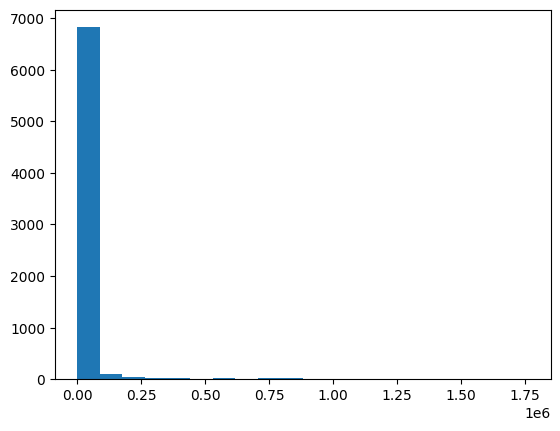

In [5]:
print(len(malwares))
plt.hist(lengths,bins=20)

Let's restrict to sequences of api calls of a reasonable size

4322


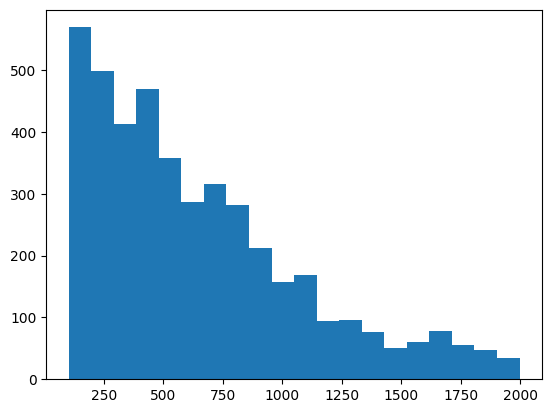

In [6]:
lengths=[x for x in lengths if x<2000 and x>100]
print(len(lengths))
plt.hist(lengths,bins=20)

indices_train_test=[x for x in indices if len(malwares[x])>100 and len(malwares[x])<2000] 

We split the dataset in a train set and a test set

In [7]:
def split_train_test(indices_train_test, alpha) :
    #alpha is the probability to lie in the test set
    indices_test=[]
    indices_train=[]
    for index in indices_train_test :
        u = np.random.rand()
        if u < alpha : 
            indices_test.append(index)
        else :
            indices_train.append(index)
    return indices_test, indices_train

indices_test, indices_train = split_train_test(indices_train_test, .20)

malwares_test, malwares_train = [malwares[i] for i in indices_test] , [malwares[i] for i in indices_train]

labels_test, labels_train = [labels[i] for i in indices_test] , [labels[i] for i in indices_train]



Distribution of the labels in the train set:

In [8]:
print(np.unique(np.array(labels_train),return_counts=True))

(array([0, 1, 2, 3, 4, 5, 6, 7]), array([157, 544, 586, 435, 421, 519, 299, 476]))


For each malware let us record the frequencies of each possible api call in a vector of length 278:

In [9]:
def most_naive_statistical_test(indices,len_of_range):
    record = []
    for i in indices :
        vec=[]
        malware=np.array(malwares[i])
        for var in range(len_of_range) :
            vec.append(np.sum(np.equal(malware,var)))
        record.append(vec)
    return np.array(record, dtype=float)

naive_train=most_naive_statistical_test(indices_train,278)
naive_test=most_naive_statistical_test(indices_test,278)

Since the sequences have variable size it seems natural to normalise these vectors of length 278.

In [10]:
naive_train/=naive_train.std(axis=1)[:,None]
naive_test/=naive_test.std(axis=1)[:,None]

Note that each of our vector has non negative coordinates, and lie on the sphere of radius 1 in the 278 dimensional space. This dimension is too large to use the usual geometric tools like K-Means and KNN (they don't behave well in large dimensions). So let us reduce the dimension :

In [11]:
kept_dimensions = 12

from sklearn.decomposition import PCA
pca = PCA(n_components=kept_dimensions)
pca.fit(naive_train)
print(np.cumsum(pca.explained_variance_ratio_))    

pca_train = pca.transform(naive_train)
pca_test  = pca.transform(naive_test)


[0.23015396 0.3938266  0.49967131 0.5599534  0.60339495 0.64133237
 0.67347146 0.70302553 0.72776238 0.74909727 0.76677743 0.7830551 ]


### K-means

Now we can apply K-means to see whether the geometry we obtained allows to clusterize the malwares according to their labels.

In [12]:
from sklearn.cluster import KMeans

def K_Means_naive( state ):
    print(f"state:{state}")
    print("Distributions of classes in the clusters:")
    kmeans = KMeans(n_clusters=8, random_state=state, n_init=20).fit(naive_train)
    clusters=[[],[],[],[],[],[],[],[]]
    for x in range(len(indices_train)):
        clusters[kmeans.labels_[x]].append(labels[indices_train[x]])
    for c in clusters :
        print(np.unique(c,return_counts=True))

for state in range(5) :
    K_Means_naive( state )

state:0
Distributions of classes in the clusters:
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 56,  19, 232,  37,  15,  34,  35,  48]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 38, 244, 175, 154, 186, 252,  89, 212]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 44, 104,  30,  77,  83,  97,  29,  81]))
(array([1, 2, 4, 5, 6, 7]), array([49,  1,  4, 10,  2, 19]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([10, 21, 90, 79, 29, 23, 40, 31]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 5,  8, 15, 18, 27, 14,  1, 12]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 1, 51, 14, 31, 44, 48, 52, 58]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 3, 48, 29, 39, 33, 41, 51, 15]))
state:1
Distributions of classes in the clusters:
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 1, 50, 13, 30, 41, 47, 50, 56]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 44, 107,  31,  75,  82,  99,  28,  83]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 38, 242, 174, 155, 187, 249,  90, 210]))
(array([0, 1, 2, 3, 4, 5, 6, 7]), array([ 56,  19

**Conclusion:** The naive method associated to K-Means does not allow to have an efficient clustering (in the sense that the clusters are very etherogeneous)

### KNN

Let's try a KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(naive_train,[labels[i] for i in indices_train])
pred=neigh.predict(naive_test)

let's compare pred and true labels

In [14]:
accuracy = np.sum(np.equal(pred,np.array([labels[i] for i in indices_test])))/len(indices_test)
print(accuracy)

0.5242937853107345


**Conclusion:** Interestingly, frequencies already allow to have quite good predictions compares to a random prediction that would result in a 12.5% accuracy.  

**Challenge**: do better !

## Using HMMs to associate coordinates to our malwares

In [15]:
print(uniques)

(array(['Adware', 'Backdoor', 'Downloader', 'Dropper', 'Spyware', 'Trojan',
       'Virus', 'Worms'], dtype='<U10'), array([ 379, 1001, 1001,  891,  832, 1001, 1001, 1001]))


### The Baum Welch algorithm to train HMMs

In [16]:
def Baum_Welch_Norm_step(a,b,init,obs) :
    N=a.shape[0]
    M=b.shape[0]
    T=len(obs)
    cs=[]

    # compute the alphas
    alphas=np.zeros([a.shape[0],len(obs)])
    alpha=(b[obs[0],:].ravel())*(init.ravel())
    #print("alpha : ",alpha)
    c=np.sum(alpha)
    #print("c = ",c)
    cs.append(1/c)
    alpha/=c
    alphas[:,0]=alpha
    #print("alphas : ",alphas)
    for i in range(1,len(obs)) :
        alpha= b[obs[i],:]*np.matmul(a,alpha)
        #print(i,"alpha =", alpha)
        c=np.sum(alpha)
        #print(i,"c =", c)
        cs.append(1/c)
        alpha/=c
        alphas[:,i]=alpha


    # Compute the betas

    betas=np.zeros([a.shape[0],T])
    beta=np.ones(a.shape[0])*cs[T-1]
    betas[:,T-1]=beta
    for i in range(1,T-1) :
        beta=np.matmul(b[obs[T-i],:]*beta,a)
        beta*=cs[T-i-1]
        betas[:,T-i-1]=beta


    #Compute the lambdas
    lambdas=np.zeros([N,N,T-1])
    for s in range(T-1) :
        lambdas[:,:,s]=np.transpose((betas[:,s+1]*b[obs[s+1],:])*np.transpose(a*alphas[:,s]))


    #Compute the gammas
    gammas=np.sum(lambdas, axis=0)

    #Compute new B
    sumgammas=np.sum(gammas,axis=1)
    new_B=np.zeros([M,N])
    for i in range(M) :
        mask=np.array([o==i for o in obs[:-1] ])*1.0
        new_B[i,:]=(np.sum(gammas*mask, axis=1)/sumgammas)

    #Compute new A
    sumlambd=np.sum(lambdas,axis=2)
    new_A=sumlambd/sumgammas

    #Compute new init
    new_init=gammas[:,0]

    #Compute log likehood
    log_lik=-1*np.sum(np.log(np.array(cs)))

    return new_A,new_B,new_init,log_lik


def random_init_prob_cols(n_rows,n_cols) :
    answer=np.random.randn(n_cols*n_rows).reshape((n_rows,n_cols))
    answer=np.exp(answer)
    answer/=np.sum(answer,axis=0)[None,:]
    return answer

def train_HMM_on_seq_of_api_calls(line_as_number,n_hidden, n_obs):

    
    est_A=random_init_prob_cols(n_hidden,n_hidden)
    est_B=random_init_prob_cols(n_obs,n_hidden)
    est_init=np.ones(n_hidden)/n_hidden

    for _ in range(15) :
        est_A,est_B,est_init,log_lik=Baum_Welch_Norm_step(est_A,est_B,est_init,line_as_number)
        est_B = np.maximum(est_B,.000001)
        est_B /= (est_B.sum(axis=0)[None,:])
        #print("  ----->",_, " : " ,log_lik)
    
    return est_A, est_B, est_init

def log_lik(a,b,init,obs):
    N=a.shape[0]
    M=b.shape[0]
    T=len(obs)
    cs=[]

    # compute the alphas
    alphas=np.zeros([a.shape[0],len(obs)])
    alpha=(b[obs[0],:].ravel())*(init.ravel())
    #print("alpha : ",alpha)
    c=np.sum(alpha)
    #print("c = ",c)
    cs.append(1/c)
    alpha/=c
    alphas[:,0]=alpha
    #print("alphas : ",alphas)
    for i in range(1,len(obs)) :
        alpha= b[obs[i],:]*np.matmul(a,alpha)
        #print(i,"alpha =", alpha)
        c=np.sum(alpha)
        #print(i,"c =", c)
        cs.append(1/c)
        alpha/=c
        alphas[:,i]=alpha

    log_lik=-1*np.sum(np.log(np.array(cs)))
    return log_lik

So each malware allows us to define a function from programs (in fact sequences of api calls) to $\mathbb R$:

In [17]:
def get_hmm_f_for_row(row, n_hidden, n_obs):
    a, b , init = train_HMM_on_seq_of_api_calls(row, n_hidden, n_obs)
    init=np.ones(n_hidden)/n_hidden
    def log_lik_hmm(other_row):
        return log_lik(a,b,init,other_row)
    return log_lik_hmm

The class individual:

In [84]:
class individual() :
    def __init__(self, indices_for_sequence_of_malwares_train , print_details=False) :
        self.indices=indices_for_sequence_of_malwares_train
        self.representatives = [malwares_train[i] for i in self.indices] #2 per class (2 for the first class, then 2 for the second class etc.)
        self.functions_associated_to_representatives=[]
        self.frame=None
        self.compute_frame()
        self.print_details=print_details

    def compute_coordinates(self) :
        for row in self.representatives :
            f_row = get_hmm_f_for_row(np.array(row), 20, 278 )
            self.functions_associated_to_representatives.append(f_row)

    def compute_embedded_image(self,malwares) :
        log_liks = [[f(x) for f in self.functions_associated_to_representatives] for x in malwares]
        log_liks=np.array(log_liks)
        log_liks/=np.std(log_liks,axis=1)[:,None]
        return log_liks
        
    def compute_frame(self) :
        self.compute_coordinates()
        
        self.frame=self.compute_embedded_image(self.representatives)

    def accuracy(self, n) :
        from sklearn.decomposition import PCA
        pca = PCA(n_components=6)
        pca.fit(self.frame)
        if self.print_details :
            print(np.cumsum(pca.explained_variance_ratio_))
        self.frame_pca=pca.transform(self.frame)
        
        from sklearn.neighbors import KNeighborsClassifier
        neigh = KNeighborsClassifier(n_neighbors=1)
        neigh.fit(self.frame_pca,np.concatenate([i*np.ones(2,dtype=int) for i in range(8)]))

        

        def test(i) :
            m=malwares_train[i]
            coord_m=np.array([f(m) for f in self.functions_associated_to_representatives])
            coord_m/=coord_m.std()
            coord_m = pca.transform([coord_m])
            p=neigh.predict(coord_m)
            return  p[0] == labels_train[i] 
            
        def statistics (n) :
            part=0
            for i in random.choices(list(range(len(malwares_train))), k=n) :
                if i%100==0 : 
                    print("testing :",i)
                part+=test(i)
            return part/n

        return statistics(n)

        
    
        

In [85]:
#Example :
import random 

labels_train=np.array(labels_train)

def get_random_genom() :
    indices_of_representatives = []
    for x in [dic[malware_type] for malware_type in uniques[0]] :
        indices_of_malwares_of_type_x = [ i for i in range(len(malwares_train)) if ( labels_train[i]==x   ) and (len(malwares_train[i]<500))] #last condition to be deleted later
        sample=random.sample(indices_of_malwares_of_type_x,2)
        indices_of_representatives+=sample
    return indices_of_representatives
    
def random_individual() :
    return individual(get_random_genom())

for i in range(10) :
    ind=random_individual()
    print("accuracy on the 1000 first malwares :",ind.accuracy(1000))

testing : 3400
testing : 3400


KeyboardInterrupt: 

## Genetic algorithm to choose the frame

We see the list of 16 indices of chosen malwares as the DNA of our individuals.

We begin with 12 individuals and compute their accuracy on a test set.

We keep only the two best individuals (the one that have the highest accuracy) 

We choose 10 new individuals (their children) as follows :

    the DNA of a child is made by choosing one chromosom in the genom of its parents
    4 of the chromosoms, chosen randomly are mutated

In [ ]:
def next_generation(generation ) :
    accuracies = np.array([ind.accuracy(400) for ind in generation])
    print("accuracies=", accuracies)
    sorted=np.sort(accuracies)
    max_vals= sorted[-2:]
    parents=[generation[i] for i in range(12) if accuracies[i] in max_vals]
    answer=[parents[i] for i in range(2)]
    
    for i in range(10) :    
        indices_mother=parents[0].indices
        indices_father=parents[1].indices
        indices_child=[]
        for j in range(8) :
            u=np.random.rand()
            if u>.5 :
                indices_child.append(indices_mother[2*j+1])
            else :
                indices_child.append(indices_mother[2*j])
            u=np.random.rand()
            if u>.5 :
                indices_child.append(indices_father[2*j+1])
            else :
                indices_child.append(indices_father[2*j])
        mutations = random.choices(list(range(16)),k=4)
        random_genom = get_random_genom()
        for j in mutations :
            indices_child[j] = random_genom[j]
        answer.append(individual(indices_child))
    return answer
            
            
            
            
    
    
    

def genetic(n_generations) :

    # Choose 12 random individuals
    generation =[]
    for i in range(12) :
        generation.append(random_individual())
    print([ind.indices for ind in generation])
    for g in range(n_generations) :
        generation = next_generation(generation)
        print(f"------------------------------------- generation {g}")
        print([ind.indices for ind in generation])

    return generation


genetic(10)


# Older material

In [45]:
ind.accuracy(100)

2914 :  [False]
1577 :  [False]
1540 :  [False]
1697 :  [ True]
227 :  [ True]
1428 :  [ True]
2689 :  [ True]
3062 :  [ True]
2782 :  [False]
2320 :  [False]
279 :  [False]
55 :  [ True]
3404 :  [False]
3388 :  [False]
1380 :  [False]
369 :  [ True]
0
20
40
60
80


array([0.1])

In [21]:
def trying() :
    import random 
    hyperparameter = 2
    representatives = []
    print ("trying : ")
    for x in uniques[0] :
        indices_of_malwares_of_type_x = [ i for i in range(len(malwares)) if ( labels[i]==x  and len(malwares[i])<5000 ) ] 
        sample=random.sample(indices_of_malwares_of_type_x,hyperparameter)
        print(x," : ",sample)
        representatives+=[malwares[i] for i in sample]

    
    
    count=0
    functions_associated_to_representatives=[]
    for row in representatives :
        print(count)
        count+=1
        f_row = get_hmm_f_for_row(np.array(row), 20, 267 )
        functions_associated_to_representatives.append(f_row)
    
    #8*hyperparameter points in a 8*hyperparameter dimensional space
    
    log_liks = [[f(x) for f in functions_associated_to_representatives] for x in representatives]
    
    log_liks=np.array(log_liks).T
    
    log_liks/=np.std(log_liks,axis=1)[:,None]
    
    from sklearn.decomposition import PCA
    pca = PCA(n_components=6)
    pca.fit(log_liks)
    print(np.cumsum(pca.explained_variance_ratio_))
    
    log_liks_pca=pca.transform(log_liks)
    
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=hyperparameter)
    neigh.fit(log_liks_pca,np.concatenate([i*np.ones(hyperparameter,dtype=int) for i in range(8)]))
    
            
    
    
    
    
    
    def statistics (n) :
        tot=0
        tot_laxist=0
        tot_severe=0
        for i in range(n) :
            if len(malwares[i])<20000 :
                tot+=1
                if i%20==0 : 
                    print(i)
                laxist,severe =test(i)
                tot_laxist+=laxist
                tot_severe+=severe
        return tot_laxist/tot, tot_severe/tot
    
    print(statistics(200))

for i in range(10) :
    trying()
    print("-----------------------------------------------------------------------------------------")

trying : 


ValueError: Sample larger than population or is negative

In [ ]:
# an individual is a choice of hyperparameter*8 malwares
# a generation is a choice of 10 individuals
# for each generation we keep the best three individuals, and 7 children obtained by mixing the malwares in the individuals and changing randomly 4 of the malwares




def genetic_search(n_generations) :
    


In [ ]:
print(uniques[0])

In [ ]:
100/8


In [ ]:
test(0)

In [ ]:
log_liks=np.array(log_liks)
log_liks_centered=np.array(log_liks) - np.array([ log_liks[i,i] for i in range(40)]) 
log_liks_normalized= log_liks_centered/np.min(log_liks,axis=1)[:,None]
plt.imshow(log_liks_normalized)

In [ ]:
malwares = malwares.dropna(subset='malware')


In [ ]:
malwares.isnull().sum().sum()

In [ ]:
indexes = np.arange(malwares.shape[0])
np.random.shuffle(indexes)
random_choices = indexes[:1000]
D= malwares.iloc[random_choices, 1:]
malwares= malwares.iloc[:, 1:]

len(np.unique(malwares.to_numpy()))

In [ ]:
from sklearn.cluster import KMeans
y=[]
z=[]
max_clust = 31
for i in range(2,max_clust):
    model = KMeans(n_clusters=i, random_state=0, n_init='auto')
    model.fit(test)
    y.append(model.inertia_)
for i in range(2,max_clust):
    model = KMeans(n_clusters=i, random_state=0, n_init='auto')
    model.fit(randomised_test)
    z.append(model.inertia_)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(range(2, max_clust), y, label='test')
plt.plot(range(2, max_clust), z, label='randomised_test')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Choosing Number of Clusters')
plt.legend()
plt.show() 
"""
plt.plot(range(2,max_clust),y)
plt.plot(range(2,max_clust),z)"""

In [ ]:
test = malwares[malwares['malware'] == 1].iloc[:,1:101].to_numpy()
print('unique test:',np.unique(test))
print(np.unique(test).size)

def transle_to_norm(s):
    u = np.unique(s)
    l_u = u.size
    translator = dict()
    for w,i in zip(u, range(l_u)):
        translator[w]=i
    translaed_s = [[translator[w] for w in row]for row in s]

    return np.array(translaed_s), l_u

x,l=transle_to_norm(test)
print('x:',np.unique(x))
print('l:',l)


randomised_test = test.copy()
print(type(randomised_test))
print(test.shape)
np.random.shuffle(randomised_test)
print('test shape:', test.shape)
#np.reshape(randomised_test,test.shape)
print('randomised test shape:', randomised_test.shape)
print('random:',randomised_test[:2])
print('test:', test[:2])

In [ ]:
def Baum_Welch_Norm_step(a,b,init,obs) :
    N=a.shape[0]
    M=b.shape[0]
    T=len(obs)
    cs=[]

    # compute the alphas
    alphas=np.zeros([a.shape[0],len(obs)])
    alpha=(b[obs[0],:].ravel())*(init.ravel())
    #print("alpha : ",alpha)
    c=np.sum(alpha)
    #print("c = ",c)
    cs.append(1/c)
    alpha/=c
    alphas[:,0]=alpha
    #print("alphas : ",alphas)
    for i in range(1,len(obs)) :
        alpha= b[obs[i],:]*np.matmul(a,alpha)
        #print(i,"alpha =", alpha)
        c=np.sum(alpha)
        #print(i,"c =", c)
        cs.append(1/c)
        alpha/=c
        alphas[:,i]=alpha


    # Compute the betas

    betas=np.zeros([a.shape[0],T])
    beta=np.ones(a.shape[0])*cs[T-1]
    betas[:,T-1]=beta
    for i in range(1,T-1) :
        beta=np.matmul(b[obs[T-i],:]*beta,a)
        beta*=cs[T-i-1]
        betas[:,T-i-1]=beta


    #Compute the lambdas
    lambdas=np.zeros([N,N,T-1])
    for s in range(T-1) :
        lambdas[:,:,s]=np.transpose((betas[:,s+1]*b[obs[s+1],:])*np.transpose(a*alphas[:,s]))


    #Compute the gammas
    gammas=np.sum(lambdas, axis=0)

    #Compute new B
    sumgammas=np.sum(gammas,axis=1)
    new_B=np.zeros([M,N])
    for i in range(M) :
        mask=np.array([o==i for o in obs[:-1] ])*1.0
        new_B[i,:]=(np.sum(gammas*mask, axis=1)/sumgammas)

    #Compute new A
    sumlambd=np.sum(lambdas,axis=2)
    new_A=sumlambd/sumgammas

    #Compute new init
    new_init=gammas[:,0]

    #Compute log likehood
    log_lik=-1*np.sum(np.log(np.array(cs)))

    return new_A,new_B,new_init,log_lik


In [ ]:
def random_init_prob_cols(n_rows,n_cols) :
    answer=np.random.randn(n_cols*n_rows).reshape((n_rows,n_cols))
    answer=np.exp(answer)
    answer/=np.sum(answer,axis=0)[None,:]
    return answer

def train_HMM_on_seq_of_api_calls(line_as_number,n_hidden, n_obs):

    
    est_A=random_init_prob_cols(n_hidden,n_hidden)
    est_B=random_init_prob_cols(n_obs,n_hidden)
    est_init=np.ones(n_hidden)/n_hidden

    for _ in range(15) :
        est_A,est_B,est_init,log_lik=Baum_Welch_Norm_step(est_A,est_B,est_init,line_as_number)
        est_B = np.maximum(est_B,.000001)
        est_B /= (est_B.sum(axis=0)[None,:])
        #print("  ----->",_, " : " ,log_lik)
    
    return est_A, est_B, est_init



In [ ]:
def log_lik(a,b,init,obs):
    N=a.shape[0]
    M=b.shape[0]
    T=len(obs)
    cs=[]

    # compute the alphas
    alphas=np.zeros([a.shape[0],len(obs)])
    alpha=(b[obs[0],:].ravel())*(init.ravel())
    #print("alpha : ",alpha)
    c=np.sum(alpha)
    #print("c = ",c)
    cs.append(1/c)
    alpha/=c
    alphas[:,0]=alpha
    #print("alphas : ",alphas)
    for i in range(1,len(obs)) :
        alpha= b[obs[i],:]*np.matmul(a,alpha)
        #print(i,"alpha =", alpha)
        c=np.sum(alpha)
        #print(i,"c =", c)
        cs.append(1/c)
        alpha/=c
        alphas[:,i]=alpha

    log_lik=-1*np.sum(np.log(np.array(cs)))
    return log_lik

In [ ]:
def get_hmm_f_for_row(row, n_hidden, n_obs):
    a, b , init = train_HMM_on_seq_of_api_calls(row, n_hidden, n_obs)
    init=np.ones(n_hidden)/n_hidden
    def log_lik_hmm(other_row):
        return log_lik(a,b,init,other_row)
    return log_lik_hmm

f =get_hmm_f_for_row(x[10],2,l )
g =get_hmm_f_for_row(x[50],2,l )
h =get_hmm_f_for_row(x[99],2,l )

""" for i in range(1,l) : 
    f = get_hmm_f_for_row(x[i],2,l)
 """

In [ ]:
#%matplotlib
L= [f(x[i]) for i in range(l)]
M= [g(x[i]) for i in range(l)]
N = [h(x[i]) for i in range(l)]
fig = plt.figure()
ax = fig.add_subplot(projection= '3d')

ax.scatter(L,M,N)

In [ ]:
def mix_step(D,indicies,l):
    #d is dataset 
    #indicies  IS LISE OF INDICIES

    fs = [get_hmm_f_for_row(D[i], 2, l) for i in indicies]
    cloud=np.array([[fs[i](x) for i in range(len(indicies))] for x in D])
    from sklearn.cluster import KMeans
    k_means_model= KMeans(n_clusters=len(indicies), random_state=0, n_init='auto')
    k_means_model.fit(cloud)
    cs = k_means_model.cluster_centers_
    from sklearn.neighbors import KNeighborsClassifier
    knn_model = KNeighborsClassifier(n_neighbors=1)
    knn_model.fit(cloud, range(cloud.shape[0]))
    cs_closet = knn_model.predict(cs)

    return cs_closet,k_means_model.inertia_



In [ ]:
#%matplotlib
new_x = x.copy()
np.random.shuffle(new_x)
new_x = new_x[:1000]
indices = [0,1,2]
inertias = []
mix_step(new_x, indices,l)
for i in range (10):
    for j in range(10):
        indices, inertia= mix_step(new_x, indices,l,)
        inertias.append(inertia)
        print(indices)

plt.hist(inertias)